In [39]:
import pandas as pd
import numpy as np
import re
from datetime import timedelta
from connection_keys import connect_bq_client
import statsmodels.api as sm
import os
import warnings
import itertools
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.set_option('display.max_colwidth', None)

In [2]:
client = connect_bq_client()

sql = """
    SELECT *
    FROM `db_market_product.gpu`
    ORDER BY dt_carga asc
"""

df = client.query(sql).to_dataframe()
df['data'] = df.dt_carga.dt.date
df['ds_nome_produto'] = df['ds_nome_produto'].str.upper()

In [3]:
df.sample(10)

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data
92806,Powercolor,PLACA DE VIDEO POWERCOLOR RADEON RED DEVIL RX ...,14241.36,12105.16,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_...",False,Kabum,2022-10-14 22:27:01.802785+00:00,2022-10-14
6428,Sapphire,PLACA DE VIDEO SAPPHIRE RADEON R7 360 2GB GDDR...,759.00,759.00,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-09-30 10:01:23.630323+00:00,2022-09-30
128152,Gainward,"PLACA DE VÍDEO GAINWARD GEFORCE GT 1030 2GB, D...",899.80,899.80,0.0,2,None,True,Kabum,2022-10-20 10:03:05.868121+00:00,2022-10-20
337145,MSI,PLACA DE VIDEO MSI GEFORCE GTX 1660 SUPER VENT...,2272.61,2272.61,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-11-27 22:01:28.816066+00:00,2022-11-27
2473,PCYES,PLACA DE VÍDEO PCYES NVIDIA GEFORCE GTX 1050 T...,1647.05,1399.99,15.0,74,"[{'ds_oferta_nome': 'Setembro Tech', 'vl_ofert...",True,Kabum,2022-09-29 12:26:15.112196+00:00,2022-09-29
70614,Zotac,PLACA DE VIDEO ZOTAC GEFORCE GT 1030 2GB GDDR5...,544.08,544.08,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-10-12 01:39:15.784415+00:00,2022-10-12
74494,DEX,"PLACA DE VÍDEO NVIDIA GEFORCE GT-210, 1GB, DDR...",302.41,302.41,0.0,0,None,False,Kabum,2022-10-12 22:27:35.091882+00:00,2022-10-12
133965,XFX,PLACA DE VIDEO XFX RADEON RX 5700 8GB GDDR6 25...,2045.42,2045.42,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-10-21 10:01:40.506674+00:00,2022-10-21
410480,EVGA,PLACA DE VIDEO EVGA GEFORCE GTX 1060 3GB GDDR5...,1078.40,1078.40,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-12-11 10:01:29.550701+00:00,2022-12-11
214613,Mancer,"PLACA DE VIDEO MANCER RADEON RX 550, 4GB, GDDR...",1090.90,744.20,12.0,<NA>,"[{'ds_oferta_nome': 'NovemBlack', 'vl_oferta_p...",IN_STOCK,Pichau,2022-11-05 10:02:01.888203+00:00,2022-11-05


In [4]:
df.iloc[df.index == 187149]['ds_nome_produto'].tolist() # ds_nome_produto_resumido ds_nome_produto

['PLACA DE VÍDEO EVGA NVIDIA GEFORCE RTX 3060 XC BLACK GAMING 12G P5 3655 KR, LHR,  12GB GDDR6, DLSS, RAY TRACING - 12G-P5-3655-KR']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544824 entries, 0 to 544823
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   ds_marca                    544824 non-null  object             
 1   ds_nome_produto             544824 non-null  object             
 2   vl_preco_atual              544824 non-null  float64            
 3   vl_preco_com_desconto       544824 non-null  float64            
 4   vl_porcentagem_do_desconto  544824 non-null  float64            
 5   qt_quantidade_estoque       203417 non-null  Int64              
 6   oferta                      544824 non-null  object             
 7   ds_disponibilidade          544824 non-null  object             
 8   loja                        544824 non-null  object             
 9   dt_carga                    544824 non-null  datetime64[ns, UTC]
 10  data                        544824 non-null 

In [6]:
df.groupby(['dt_carga'])['loja'].count()
df.groupby(['data', 'loja'])['dt_carga'].nunique()

data        loja  
2022-09-29  Kabum     2
            Pichau    2
2022-09-30  Kabum     2
            Pichau    2
2022-10-01  Kabum     2
                     ..
2023-01-02  Pichau    2
2023-01-03  Kabum     2
            Pichau    2
2023-01-04  Kabum     1
            Pichau    1
Name: dt_carga, Length: 196, dtype: int64

In [7]:
# df_datas_loja = df.groupby(['data', 'loja'])['dt_carga'].nunique()
# df_datas_loja
maxDf = df.groupby(['data'])['dt_carga'].max()
minDf = df.groupby(['data'])['dt_carga'].min()
maxDates = maxDf.tolist()
df = df.loc[df['dt_carga'].isin(maxDates)]

In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
# nltk.download('popular') # Rodar apenas uma vez para fazer a instalação


In [9]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent
ex = "PLACA DE VÍDEO ASUS NVIDIA GEFORCE GTX 1050 TI OC CERBERUS, 4GB GDDR5 - CERBERUS-GTX1050TI-O4G"
sent = preprocess(ex)
sent
pattern = 'NP: {<NNP>*<CD>*<NNP>}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)
print(cs)

(S
  (NP
    PLACA/NNP
    DE/NNP
    VÍDEO/NNP
    ASUS/NNP
    NVIDIA/NNP
    GEFORCE/NNP
    GTX/NNP
    1050/CD
    TI/NNP)
  (NP OC/NNP CERBERUS/NNP)
  ,/,
  (NP 4GB/CD GDDR5/NNP)
  -/:
  CERBERUS-GTX1050TI-O4G/NN)


In [10]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(cs)
pprint(iob_tagged)
ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(ex)))
print(ne_tree)

[('PLACA', 'NNP', 'B-NP'),
 ('DE', 'NNP', 'I-NP'),
 ('VÍDEO', 'NNP', 'I-NP'),
 ('ASUS', 'NNP', 'I-NP'),
 ('NVIDIA', 'NNP', 'I-NP'),
 ('GEFORCE', 'NNP', 'I-NP'),
 ('GTX', 'NNP', 'I-NP'),
 ('1050', 'CD', 'I-NP'),
 ('TI', 'NNP', 'I-NP'),
 ('OC', 'NNP', 'B-NP'),
 ('CERBERUS', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('4GB', 'CD', 'B-NP'),
 ('GDDR5', 'NNP', 'I-NP'),
 ('-', ':', 'O'),
 ('CERBERUS-GTX1050TI-O4G', 'NN', 'O')]
(S
  (ORGANIZATION PLACA/NNP)
  (PERSON DE/NNP)
  VÍDEO/NNP
  ASUS/NNP
  NVIDIA/NNP
  GEFORCE/NNP
  GTX/NNP
  1050/CD
  TI/NNP
  OC/NNP
  CERBERUS/NNP
  ,/,
  4GB/CD
  (ORGANIZATION GDDR5/NNP)
  -/:
  CERBERUS-GTX1050TI-O4G/NN)


In [13]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [5]:
def get_resume_product_name(name):
    # string = df['nome_produto'][df['id'] == 259].item()
    pattern = "(RTX|GTX|GT|RX|WX|Quadro|R7|R5|R9|HD)\s(\d+)"
    resume_name = re.search(pattern, name)
    if resume_name is None:
        return ''
    else:
        return resume_name.group()

df['ds_nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['ds_nome_produto']), axis=1)

In [31]:
def get_resume_product_name(name):
    pattern = "(RTX|GTX|GT|RX|WX|QUADRO|R7|R5|R9|HD|ARC)(.?.?)((\w*)\d+)( ?(TI|XT|X|SUPER))?"
    resume_name = re.search(pattern, name)
    if resume_name is None:
        return None
    else:
        return resume_name.group().strip()

df['ds_nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['ds_nome_produto']), axis=1)

In [32]:
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262071 entries, 2663 to 544823
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   ds_marca                    262071 non-null  object             
 1   ds_nome_produto             262071 non-null  object             
 2   vl_preco_atual              262071 non-null  float64            
 3   vl_preco_com_desconto       262071 non-null  float64            
 4   vl_porcentagem_do_desconto  262071 non-null  float64            
 5   qt_quantidade_estoque       99064 non-null   Int64              
 6   oferta                      262071 non-null  object             
 7   ds_disponibilidade          262071 non-null  object             
 8   loja                        262071 non-null  object             
 9   dt_carga                    262071 non-null  datetime64[ns, UTC]
 10  data                        262071 non-nu

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data,ds_nome_produto_resumido
542200,PNY,"PLACA DE VIDEO PNY GEFORCE GTX 1660 TI, 6GB, G...",2478.02,1882.34,12.0,<NA>,"[{'ds_oferta_nome': 'Ano Novo - Next Level', '...",IN_STOCK,Pichau,2023-01-04 10:01:49.846600+00:00,2023-01-04,GTX 1660 TI
137515,Zotac,PLACA DE VIDEO ZOTAC GEFORCE RTX 2070 8GB GDDR...,3294.28,3294.28,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-10-21 22:01:40.223371+00:00,2022-10-21,RTX 2070
15039,Evga,PLACA DE VÍDEO EVGA GEFORCE RTX 2060 XC 6GB GD...,6930.00,6930.00,0.0,1,None,False,Kabum,2022-10-01 22:07:59.247261+00:00,2022-10-01,RTX 2060 X
413209,Asus,PLACA DE VIDEO ASUS RADEON RX 570 4GB OC GDDR5...,1216.70,1216.70,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-12-11 22:01:32.006355+00:00,2022-12-11,RX 570
233207,Galax,PLACA DE VIDEO GALAX GEFORCE RTX 3050 1-CLICK ...,2953.41,2159.08,12.0,<NA>,"[{'ds_oferta_nome': 'NovemBlack', 'vl_oferta_p...",IN_STOCK,Pichau,2022-11-08 22:02:26.673882+00:00,2022-11-08,RTX 3050
541122,Asus,PLACA DE VÍDEO RTX 3060 TI O8G V2 ASUS NVIDIA ...,5836.90,5836.90,0.0,0,None,False,Kabum,2023-01-03 22:01:46.720353+00:00,2023-01-03,RTX 3060 TI
130575,MSI,PLACA DE VÍDEO MSI RTX 3060TI TWIN FAN OC EDIT...,5215.90,5215.90,0.0,0,None,False,Kabum,2022-10-20 22:04:03.540420+00:00,2022-10-20,RTX 3060TI
463684,Zotac,PLACA DE VIDEO ZOTAC GEFORCE RTX 3070 TWIN EDG...,5611.46,5611.46,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-12-20 22:01:41.420232+00:00,2022-12-20,RTX 3070
20458,PCYES,"PLACA DE VIDEO PCYES NVIDIA, GEF RTX 2060 GDD...",2299.00,2299.00,0.0,4,None,True,Kabum,2022-10-02 23:16:41.074157+00:00,2022-10-02,RTX 2060
523795,EVGA,PLACA DE VIDEO EVGA GEFORCE GTX 750 TI 1GB GDD...,431.23,431.23,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-12-31 22:01:33.791798+00:00,2022-12-31,GTX 750 TI


In [36]:
df.loc[df.ds_nome_produto_resumido.isnull()].shape
df_gpu = df.loc[~df.ds_nome_produto_resumido.isnull()]

In [37]:
df_gpu

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data,ds_nome_produto_resumido
2664,Gigabyte,"GIGABYTE GTX 1050 TI, 4GB, DDR5",1999.00,1999.00,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,GTX 1050 TI
2665,Nvidia,VGA PCI-E 1GB GALAX GEFORCE GT710 - 1GB,339.00,339.00,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,GT710
2666,Colorful,"PLACA DE VIDEO COLORFUL GT 710, 1GB DDR3",349.00,349.00,0.0,93,None,True,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,GT 710
2667,Asus,PLACA DE VÍDEO ASUS GEFORCE RTX 3080 10GB,19999.00,19999.00,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
2668,PALIT,PLACA DE VÍDEO PALIT GEFORCE RTX 3080 10GB,22099.99,22099.99,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
...,...,...,...,...,...,...,...,...,...,...,...,...
544817,Power Color,PLACA DE VÍDEO POWER COLOR RED DEVIL AMD RADEO...,8655.28,7356.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_...",False,Kabum,2023-01-04 10:01:49.846600+00:00,2023-01-04,RX 6950 XT
544818,Power Color,PLACA DE VÍDEO AXRX 6600 3DH POWER COLOR FIGHT...,3999.99,3399.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_...",False,Kabum,2023-01-04 10:01:49.846600+00:00,2023-01-04,RX 6600
544819,Power Color,PLACA DE VÍDEO RX 6800 XT POWERCOLOR AMD RADEO...,6182.34,5254.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_...",False,Kabum,2023-01-04 10:01:49.846600+00:00,2023-01-04,RX 6800 XT
544820,Power Color,PLACA DE VÍDEO RX 6600 XT POWER COLOR FIGHTER ...,3058.81,2599.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_...",False,Kabum,2023-01-04 10:01:49.846600+00:00,2023-01-04,RX 6600 XT


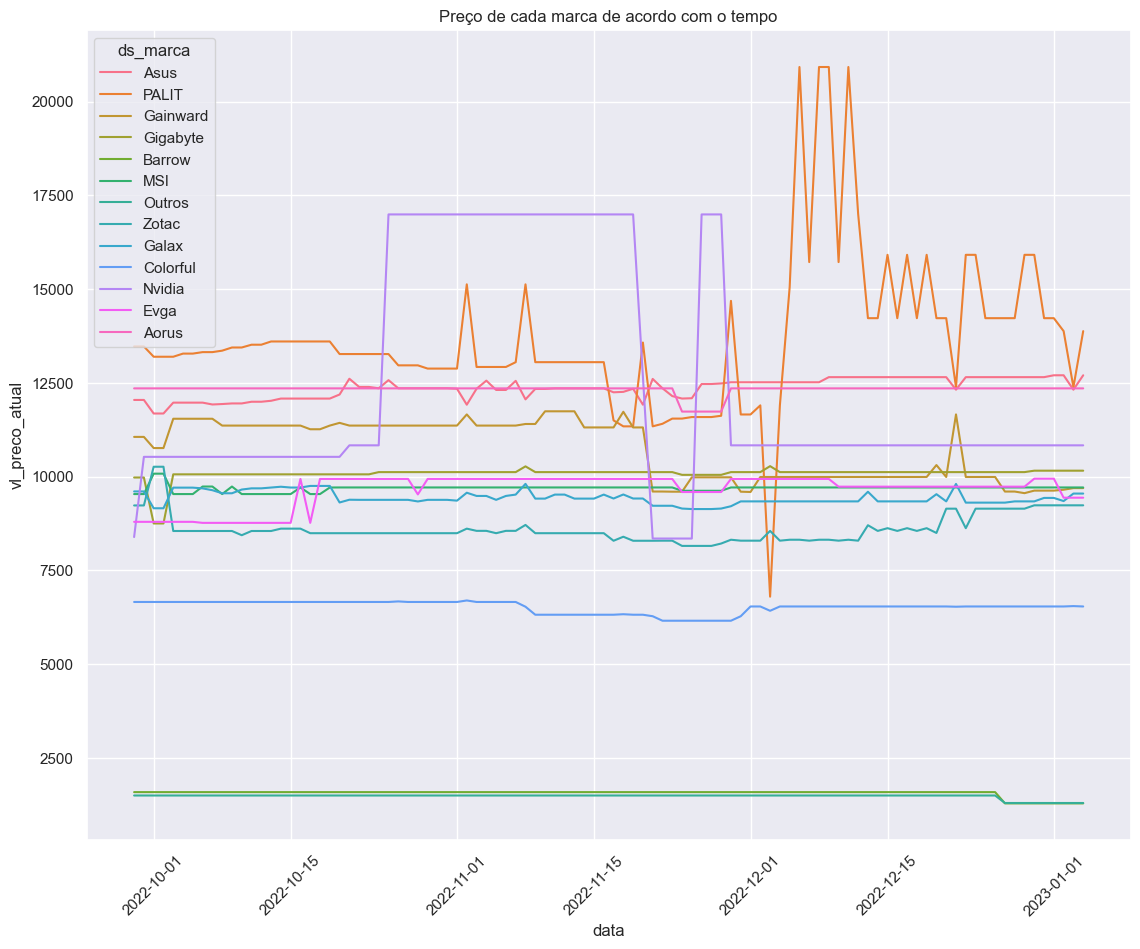

In [47]:
placa = 'RTX 3080'
# analise = df.query(f'nome_produto.str.contains("{placa}") & (~nome_produto.str.contains("TI") & ~nome_produto.str.contains("SUPER"))')
analise = df.query(f'ds_nome_produto_resumido == ("{placa}")')
# (analise['preco_atual_cartao'].groupby(analise['marca']).mean())
sns.set(rc={'figure.figsize':(12,10)})
plt.xticks(rotation = 45)
ax = sns.lineplot(
    x="data",
    y="vl_preco_atual",
    hue='ds_marca',
    data=analise,
    ci=None,
    markers=True
).set_title('Preço de cada marca de acordo com o tempo');

# Transpostar para outra lugar depois

In [11]:
# Limpa o nome de arquivos RTX A2000, 12GB
import os
import re
folder = './teste/'
for filename in os.listdir('./teste'):
    nome = re.sub(r'\([^)]*\)', '', filename)
    nome = re.sub(r'\s+(?=[.,?!])', '', nome)
    os.rename(os.path.join(folder, filename), os.path.join(folder, nome))